<a href="https://colab.research.google.com/github/Srieswari/Emotzy-/blob/main/FER_MP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [2]:
import mediapipe as mp
import cv2
from google.colab.patches import cv2_imshow
import glob
from PIL import Image
import pandas as pd
import csv
import pickle
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

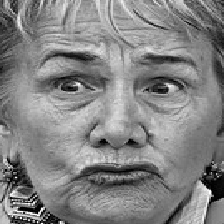

In [5]:
image_path = '/content/drive/MyDrive/train_emotion/anger/22600236939_54d0e01905_n_face.png'
frame = cv2.imread(image_path)
cv2_imshow(frame)

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


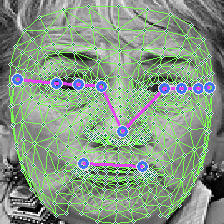

In [22]:
# Initiate the process
def get_landmarks(frame):
  with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
      image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      image.flags.writeable = False

      results = holistic.process(image)
      image.flags.writeable = True
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

      mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))

      mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2))

      mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2))

      mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

      cv2_imshow(image)
      cv2.waitKey(0)

  cv2.destroyAllWindows()
  return results

results = get_landmarks(frame)

In [23]:
num_landmarks = len(results.pose_landmarks.landmark)+len(results.face_landmarks.landmark)
landmarks = ['class']
for i in range(1, num_landmarks+1):
    landmarks += ['x{}'.format(i),'y{}'.format(i),'z{}'.format(i),'v{}'.format(i)]

In [24]:
with open('coords.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [25]:
def get_features(frame,class_name):
  with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = holistic.process(image)

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                            mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                            mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))

    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))

    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))

    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

    try:

      pose = results.pose_landmarks.landmark
      pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())

      face = results.face_landmarks.landmark
      face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())

      row = pose_row + face_row

      row.insert(0, class_name)

      with open('coords.csv', mode='a', newline='') as f:
          csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
          csv_writer.writerow(row)

    except:
        pass

  cv2.destroyAllWindows()

In [ ]:
folder_path = "/content/drive/MyDrive/train2"
files = os.listdir(folder_path)


image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg'))]

for image_files in files:

  image_file = os.path.join(folder_path, image_files)
  for images in os.listdir(image_file):

    image_path = os.path.join(image_file,images)
    img = cv2.imread(image_path)

    if img is not None:
      get_features(img,image_files)

    else:

        os.remove(image_path)
        print(f"Removed image: {images}")

print("Done")

Done


In [19]:
train_data=pd.read_csv('/content/drive/MyDrive/emotzy/coords.csv')

In [8]:
train_data

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z499,v499,x500,y500,z500,v500,x501,y501,z501,v501
0,happy,0.492909,0.662114,-3.659724,0.990151,0.607987,0.531422,-3.349121,0.989804,0.670933,...,0.056232,0.0,0.793825,0.450982,0.171100,0.0,0.818195,0.431372,0.177744,0.0
1,happy,0.313209,0.622472,-1.178704,0.986437,0.407638,0.472854,-1.339919,0.982937,0.447537,...,-0.093205,0.0,0.458319,0.337455,-0.199201,0.0,0.486534,0.315427,-0.211165,0.0
2,happy,0.442466,0.582203,-5.133046,0.996571,0.586003,0.382704,-4.743922,0.995701,0.671132,...,-0.093512,0.0,0.773123,0.328896,0.016788,0.0,0.790714,0.305553,0.019681,0.0
3,happy,0.869222,0.539454,-3.847697,0.970989,0.833805,0.390993,-3.546384,0.969919,0.853021,...,0.013462,0.0,0.868988,0.373121,0.142555,0.0,0.873220,0.362457,0.151584,0.0
4,happy,0.520912,0.659999,-4.219508,0.994786,0.650798,0.473899,-3.950647,0.994428,0.718831,...,-0.047257,0.0,0.770562,0.367130,0.028726,0.0,0.791377,0.352795,0.029906,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17373,neutral,0.493816,0.425756,-3.721504,0.998966,0.606281,0.267727,-3.461991,0.998474,0.668348,...,-0.049363,0.0,0.704070,0.211122,-0.011074,0.0,0.719263,0.193950,-0.012013,0.0
17374,neutral,0.582852,0.545912,-4.106605,0.987894,0.617231,0.357782,-3.807307,0.987292,0.668714,...,-0.001381,0.0,0.747810,0.296525,0.157982,0.0,0.757459,0.270977,0.167714,0.0
17375,neutral,0.531780,0.594599,-4.002100,0.997378,0.655306,0.427768,-3.577034,0.997103,0.722308,...,0.012907,0.0,0.839224,0.416933,0.122473,0.0,0.865077,0.403635,0.125403,0.0
17376,neutral,0.498302,0.525411,-4.312698,0.997497,0.631327,0.364987,-3.888967,0.996782,0.695289,...,-0.013845,0.0,0.725074,0.387485,0.083481,0.0,0.741406,0.374761,0.087025,0.0


In [ ]:
train_data['class'].value_counts()

class
happy      6364
neutral    4236
sad        3496
angry      3282
Name: count, dtype: int64

In [39]:
X_train = train_data.drop('class', axis=1)
y_train = train_data['class']

In [26]:
with open('coords1.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [27]:
def get_features1(frame,class_name):
  with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    results = holistic.process(image)

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                            mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                            mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))

    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))

    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))

    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
    try:

      pose = results.pose_landmarks.landmark
      pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())

      face = results.face_landmarks.landmark
      face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())

      row = pose_row + face_row

      row.insert(0, class_name)

      with open('coords1.csv', mode='a', newline='') as f:
          csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
          csv_writer.writerow(row)

    except:
        pass


  cv2.destroyAllWindows()

In [28]:
folder_path = "/content/drive/MyDrive/emotzy/test1"
files = os.listdir(folder_path)

image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg'))]
for image_files in files:
  image_file = os.path.join(folder_path, image_files)
  for images in os.listdir(image_file):
    image_path = os.path.join(image_file,images)
    img = cv2.imread(image_path)
    if img is not None:
      get_features1(img,image_files)
    else:
        os.remove(image_path)
        print(f"Removed image: {images}")

print("Done")

Done


In [21]:
test_data=pd.read_csv('/content/drive/MyDrive/emotzy/coords1.csv')

In [30]:
test_data['class'].value_counts()

class
happy      1559
neutral    1049
sad         912
angry       773
Name: count, dtype: int64

In [40]:
X_test = test_data.drop('class', axis=1) # features
y_test = test_data['class']

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif

In [8]:
log_model = LogisticRegression(solver='lbfgs', max_iter=2000,n_jobs=-1)
pipelines = {
    'lr':make_pipeline(MinMaxScaler(), log_model),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier(n_jobs=-1)),}

In [84]:
mi=mutual_info_classif(X_train, y_train)
ig_dict={}
for i in range(len(X_train.columns.to_list())):
  ig_dict[(X_train.columns.to_list())[i]]=mi[i]
ig_dict_sorted = dict(sorted(ig_dict.items(), key=lambda item: item[1], reverse=True))
selected_features = list(ig_dict_sorted.keys())[:900]

In [85]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train[selected_features], y_train)
    fit_models[algo] = model

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [86]:
fit_models

{'lr': Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('logisticregression',
                  LogisticRegression(max_iter=2000, n_jobs=-1))]),
 'rf': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier(n_jobs=-1))])}

In [87]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test[selected_features])
    print('model-',algo,'accuracy-', accuracy_score(y_test, yhat) ,'precison-', precision_score(y_test,yhat,average="micro")*100 ,'recall', recall_score(y_test,yhat,average="micro")*100 )

model- lr accuracy- 0.6212438853948288 precison- 62.12438853948288 recall 62.12438853948288
model- rf accuracy- 0.6044723969252271 precison- 60.447239692522714 recall 60.447239692522714


In [ ]:
with open('emotion.pkl', 'wb') as f:
    pickle.dump(fit_models['rf'], f)

In [ ]:
with open('emotion.pkl', 'rb') as f:
    model1 = pickle.load(f)

In [ ]:
model1

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier(n_jobs=-1))])

In [ ]:
yhat = model1.predict(X_test)

In [ ]:
cm=confusion_matrix(yhat,y_test)

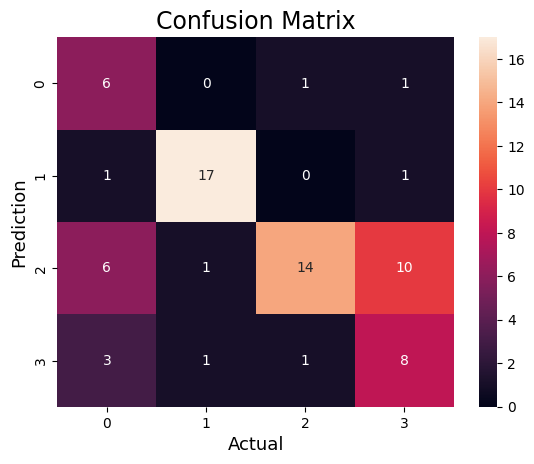

In [ ]:
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [9]:
lr=make_pipeline(MinMaxScaler(), log_model)
rf=make_pipeline(StandardScaler(), RandomForestClassifier(n_jobs=-1))

In [10]:
from sklearn.decomposition import PCA

In [57]:
pca = PCA(900)
pca.fit(X_train)
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

In [58]:
from  sklearn.ensemble import VotingClassifier

estimators = [('lr',lr),('rf', rf)]
ensemble = VotingClassifier(estimators, voting = 'soft')
ensemble.fit(X_train_pca, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                              ('logisticregression',
                                               LogisticRegression(max_iter=2000,
                                                                  n_jobs=-1))])),
                             ('rf',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(n_jobs=-1))]))],
                 voting='soft')

In [59]:
with open('ensemble_pca.pkl', 'wb') as f:
    pickle.dump(ensemble, f)

In [60]:
yhat=ensemble.predict(X_test_pca)
print(accuracy_score(yhat,y_test)*100)

0.6568832983927324


In [88]:
estimators = [('lr',lr),('rf', rf)]
ensemble_mi = VotingClassifier(estimators, voting = 'soft')
ensemble_mi.fit(X_train, y_train)
with open('ensemble_mi.pkl', 'wb') as f:
    pickle.dump(ensemble_mi, f)
yhat=ensemble_mi.predict(X_test)
print(accuracy_score(yhat,y_test)*100)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


64.7099930118798


In [28]:
# run the above model in ur local machine, with CV2 to recognize emotions